In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2

from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'data/hymenoptera_data'
data_dir = '/content/drive/MyDrive/image/for transfer learning'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                             shuffle=True, num_workers=4)
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


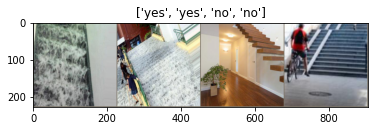

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(class_names[labels[j]])
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#model_ft = models.resnet18(pretrained=True)
model_ft = torch.load("/content/drive/MyDrive/image/mobilenetv3_model_conv_crack.pth")
#model_ft = torch.load("mobilenetv3_model_ft_crack.pth")

#num_ftrs = model_ft.fc.in_features
#num_ftrs = model_ft.classifier.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)


FileNotFoundError: ignored

In [ ]:
data_dir_crack = '/content/drive/MyDrive/image/test/yes'
data_dir_non_crack = '/content/drive/MyDrive/image/test/no'

file_list_crack = os.listdir(data_dir_crack)
file_list_non_crack = os.listdir(data_dir_non_crack)

total_count = 0
correct_count = 0
invalid_count = 0

was_training = model_ft.training
model_ft.eval()

with torch.no_grad():

    for file in file_list_crack:
        if 'jpg' in file:
            test_image = data_dir_crack + '/' + file
            #print('test:', test_image)

            image = Image.open(test_image)
            #plt.imshow(image), plt.xticks([]), plt.yticks([])

            numpy_image=np.array(image)

            #opencv_image=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
            #cv2.imshow("image",opencv_image)
            #cv2.waitKey(1)

            image = data_transforms['val'](image).unsqueeze(0).cuda()

            image = image.to(device)

            outputs = model_ft(image)
            _, preds = torch.max(outputs, 1)

            #print('outputs:', outputs);

            #print('preds', preds)
            #print('outputs: ', outputs, ', test:', test_image, ', predicted: {}'.format(class_names[preds]))
            print('test:', test_image, ', predicted: {}'.format(class_names[preds]))

            total_count = total_count + 1

            if class_names[preds] == "yes":
                correct_count = correct_count + 1
            else:
                invalid_count = invalid_count + 1

    for file in file_list_non_crack:
        if 'jpg' in file:
            test_image = data_dir_non_crack + '/' + file
            #print('test:', test_image)

            image = Image.open(test_image)
            #plt.imshow(image), plt.xticks([]), plt.yticks([])

            numpy_image=np.array(image)

            #opencv_image=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
            #cv2.imshow("image",opencv_image)
            #cv2.waitKey(1)

            image = data_transforms['val'](image).unsqueeze(0).cuda()

            image = image.to(device)

            outputs = model_ft(image)
            _, preds = torch.max(outputs, 1)

            #print('outputs:', outputs);

            #print('preds', preds)
            #print('outputs: ', outputs, ', test:', test_image, ', predicted: {}'.format(class_names[preds]))
            print('test:', test_image, ', predicted: {}'.format(class_names[preds]))

            total_count = total_count + 1

            if class_names[preds] == "no":
                correct_count = correct_count + 1
            else:
                invalid_count = invalid_count + 1

acc = correct_count / total_count

print('total_count = ', total_count)
print('correct_count = ', correct_count)
print('invalid_count = ', invalid_count)
print('accuracy = ', acc)